# MLP Classification with SUBJ Dataset
<hr>

We will build a text classification model using MLP model on the SUBJ Dataset. Since there is no standard train/test split for this dataset, we will use 10-Fold Cross Validation (CV). 

## Load the library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords, twitter_samples
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')


Bad key text.latex.unicode in file C:\Users\Diardano Raihan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\Diardano Raihan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\Diardano Raihan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
h

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

## Load the Dataset

In [3]:
corpus = pd.read_pickle('../../0_data/SUBJ/SUBJ.pkl')
corpus.label = corpus.label.astype(int)
print(corpus.shape)
corpus

(10000, 3)


sentence  label  split
0     smart and alert , thirteen conversations about...      0  train
1     color , musical bounce and warm seas lapping o...      0  train
2     it is not a mass market entertainment but an u...      0  train
3     a light hearted french film about the spiritua...      0  train
4     my wife is an actress has its moments in looki...      0  train
...                                                 ...    ...    ...
9995  in the end , they discover that balance in lif...      1  train
9996  a counterfeit 1000 tomin bank note is passed i...      1  train
9997  enter the beautiful and mysterious secret agen...      1  train
9998  after listening to a missionary from china spe...      1  train
9999  looking for a short cut to fame , glass concoc...      1  train

[10000 rows x 3 columns]

In [4]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10000 non-null  object
 1   label     10000 non-null  int32 
 2   split     10000 non-null  object
dtypes: int32(1), object(2)
memory usage: 195.4+ KB


In [4]:
corpus.groupby( by='label').count()

sentence  split
label                 
0          5000   5000
1          5000   5000

In [5]:
# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

## Raw Number of Vocabulary

In [8]:
# Build the raw vocobulary for first inspection
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_raw = tokenizer.word_index
print('\nThe vocabulary size: {}\n'.format(len(vocab_raw)))
print(vocab_raw)


The vocabulary size: 21322

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'in': 6, 'is': 7, "'s": 8, 'it': 9, 'that': 10, 'his': 11, 'with': 12, 'as': 13, 'for': 14, 'an': 15, 'but': 16, 'on': 17, 'he': 18, 'her': 19, 'this': 20, 'by': 21, 'film': 22, 'who': 23, 'has': 24, 'be': 25, 'from': 26, 'are': 27, 'its': 28, 'their': 29, 'one': 30, 'at': 31, 'movie': 32, 'you': 33, 'they': 34, "n't": 35, 'about': 36, 'not': 37, 'when': 38, 'all': 39, 'out': 40, 'she': 41, 'have': 42, 'into': 43, 'more': 44, 'life': 45, 'up': 46, 'story': 47, 'him': 48, 'than': 49, 'like': 50, 'love': 51, 'what': 52, 'so': 53, 'or': 54, 'will': 55, 'new': 56, 'time': 57, 'if': 58, 'only': 59, 'world': 60, 'there': 61, 'just': 62, 'does': 63, 'two': 64, 'man': 65, 'no': 66, 'can': 67, 'them': 68, 'young': 69, 'old': 70, 'way': 71, 'was': 72, 'good': 73, 'some': 74, 'after': 75, 'even': 76, 'most': 77, 'which': 78, 'too': 79, 'much': 80, 'been': 81, 'i': 82, 'make': 83, 'while': 84, 'family': 85, 'own': 86, 'get

<!--## Split Dataset-->

# Data Preprocessing
<hr>

## Define `clean_doc` function

In [9]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

## Develop Vocabulary

A part of preparing text for text classification involves defining and tailoring the vocabulary of words supported by the model. **We can do this by loading all of the documents in the dataset and building a set of words.**

The larger the vocabulary, the more sparse the representation of each word or document. So, we may decide to support all of these words, or perhaps discard some. The final chosen vocabulary can then be saved to a file for later use, such as filtering words in new documents in the future.

We can use `Counter` class and create an instance called `vocab` as follows:

In [10]:
from collections import Counter

vocab = Counter()

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab

In [11]:
# Example
add_doc_to_vocab(sentences, vocab)
print(len(vocab))
vocab

14591


Counter({'smart': 41,
         'alert': 5,
         'thirteen': 4,
         'convers': 17,
         'one': 784,
         'thing': 212,
         'small': 95,
         'gem': 13,
         'color': 50,
         'music': 110,
         'bounc': 3,
         'warm': 25,
         'sea': 31,
         'lap': 2,
         'island': 35,
         'shore': 10,
         'enough': 187,
         'scienc': 12,
         'send': 35,
         'home': 157,
         'think': 120,
         'mass': 11,
         'market': 12,
         'entertain': 136,
         'uncompromis': 9,
         'attempt': 93,
         'artist': 76,
         'anoth': 133,
         'light': 62,
         'heart': 147,
         'french': 45,
         'film': 1140,
         'spiritu': 24,
         'quest': 32,
         'fashion': 42,
         'model': 9,
         'seek': 52,
         'peac': 22,
         'mind': 91,
         'love': 505,
         'affair': 44,
         'veterinarian': 3,
         'non': 18,
         'practic': 13,
         

In [12]:
vocab.items()

dict_items([('smart', 41), ('alert', 5), ('thirteen', 4), ('convers', 17), ('one', 784), ('thing', 212), ('small', 95), ('gem', 13), ('color', 50), ('music', 110), ('bounc', 3), ('warm', 25), ('sea', 31), ('lap', 2), ('island', 35), ('shore', 10), ('enough', 187), ('scienc', 12), ('send', 35), ('home', 157), ('think', 120), ('mass', 11), ('market', 12), ('entertain', 136), ('uncompromis', 9), ('attempt', 93), ('artist', 76), ('anoth', 133), ('light', 62), ('heart', 147), ('french', 45), ('film', 1140), ('spiritu', 24), ('quest', 32), ('fashion', 42), ('model', 9), ('seek', 52), ('peac', 22), ('mind', 91), ('love', 505), ('affair', 44), ('veterinarian', 3), ('non', 18), ('practic', 13), ('jew', 12), ('wife', 105), ('actress', 31), ('moment', 115), ('look', 249), ('comic', 60), ('effect', 101), ('jealousi', 7), ('end', 246), ('though', 114), ('mildli', 10), ('amus', 46), ('could', 158), ('much', 266), ('work', 352), ('engag', 61), ('drama', 133), ('incis', 7), ('difficulti', 9), ('face',

In [13]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    
    return vocab
        

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    vocab = add_doc_to_vocab(train_x, vocab)
    print(len(train_x), len(test_x))
    print(len(vocab))

C:\Users\Diardano Raihan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


9000 1000
13941
9000 1000
13990
9000 1000
13994
9000 1000
13896
9000 1000
13942
9000 1000
13935
9000 1000
13963
9000 1000
13921
9000 1000
14036
9000 1000
13926


<dir>

# Bag-of-Words Representation
<hr>

Once we define our vocab obtained from the training data, we need to **convert each review into a representation that we can feed to a Multilayer Perceptron Model.**

As a reminder, here are the summary what we will do:
- extract features from the text so the text input can be used with ML algorithms like neural networks
- we do by converting the text into a vector representation. The larger the vocab, the longer the representation.
- we will score the words in a document inside the vector. These scores are placed in the corresponding location in the vector representation.

In [14]:
def doc_to_line(doc):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join([token for token in tokens])
    return line

In [15]:
def clean_docs(docs):
    lines = []
    for doc in docs:
        line = doc_to_line(doc)
        lines.append(line)
    return lines

In [16]:
print(sentences[:5])
clean_sentences = clean_docs(sentences[:5])
print()
print( clean_sentences)

['smart and alert , thirteen conversations about one thing is a small gem .', 'color , musical bounce and warm seas lapping on island shores . and just enough science to send you home thinking .', 'it is not a mass market entertainment but an uncompromising attempt by one artist to think about another .', 'a light hearted french film about the spiritual quest of a fashion model seeking peace of mind while in a love affair with a veterinarian who is a non practicing jew .', 'my wife is an actress has its moments in looking at the comic effects of jealousy . in the end , though , it is only mildly amusing when it could have been so much more .']

['smart alert thirteen convers one thing small gem', 'color music bounc warm sea lap island shore enough scienc send home think', 'mass market entertain uncompromis attempt one artist think anoth', 'light heart french film spiritu quest fashion model seek peac mind love affair veterinarian non practic jew', 'wife actress moment look comic effect

## Bag-of-Words Vectors

We will use the **Keras API** to **convert sentences to encoded document vectors**. Although the `Tokenizer` class from TF Keras provides cleaning and vocab definition, it's better we do this ourselves so that we know exactly we are doing.

In [17]:
def create_tokenizer(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

This process determines a consistent way to **convert the vocabulary to a fixed-length vector**, which is the total number of words in the vocabulary `vocab`. 

Next, documents can then be encoded using the Tokenizer by calling `texts_to_matrix()`. 

The function takes both a list of documents to encode and an encoding mode, which is the method used to score words in the document. Here we specify **freq** to score words based on their frequency in the document. 

This can be used to encode the loaded training and test data, for example:

`Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')`

`Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')`

In [9]:
#########################
# Define the vocabulary #
#########################

from scipy.io import savemat
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

counter = 0

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    
    data = {}
    
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='tfidf')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='tfidf')
    
    counter +=1
    
    data["Xtrain"] = Xtrain
    data["ytrain"] = train_y
    data["Xtest"] = Xtest
    data["ytest"] = test_y
    
    savemat("tfidf_SUBJ_"+str(counter)+".mat", data)

The number of vocab:  14000
The number of vocab:  13975
The number of vocab:  13956
The number of vocab:  13981
The number of vocab:  13942
The number of vocab:  13999
The number of vocab:  13892
The number of vocab:  13943
The number of vocab:  13986
The number of vocab:  13904


## Save into Matlab format

In [7]:
# from scipy.io import savemat
# savemat("bow_SUBJ.mat", SUBJ)

In [8]:
# SUBJ.get('2').get('Xtrain_2').shape

(9000, 14005)

# Training and Testing the Model

## MLP Model

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 100 neurons and Relu activation function
- Second hidden layer with 50 neurons and Relu activation function
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [19]:
def train_mlp(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Train and Test the Model

In [4]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_mlp(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
       
    # train the model
    model = train_mlp(Xtrain, train_y, epochs = 2)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/2
180/180 - 8s - loss: 0.5940 - accuracy: 0.7272
Epoch 2/2
180/180 - 2s - loss: 0.2640 - accuracy: 0.9049
Test Accuracy: 87.5
Epoch 1/2
180/180 - 3s - loss: 0.5628 - accuracy: 0.7626
Epoch 2/2
180/180 - 2s - loss: 0.2531 - accuracy: 0.9127
Test Accuracy: 90.2999997138977
Epoch 1/2
180/180 - 3s - loss: 0.5725 - accuracy: 0.7497
Epoch 2/2
180/180 - 2s - loss: 0.2526 - accuracy: 0.9069
Test Accuracy: 89.70000147819519
Epoch 1/2
180/180 - 2s - loss: 0.5714 - accuracy: 0.7530
Epoch 2/2
180/180 - 2s - loss: 0.2523 - accuracy: 0.9093
Test Accuracy: 90.20000100135803
Epoch 1/2
180/180 - 3s - loss: 0.5725 - accuracy: 0.7600
Epoch 2/2
180/180 - 2s - loss: 0.2504 - accuracy: 0.9091
Test Accuracy: 89.70000147819519
Epoch 1/2
180/180 - 2s - loss: 0.5797 - accuracy: 0.7424
Epoch 2/2
180/180 - 2s - loss: 0.2618 - accuracy: 0.9061
Test Accuracy: 90.2999997138977
Epoch 1/2
180/180 - 3s - loss: 0.5672 - accuracy: 0.7438
Epoch 2/2
180/180 - 2s - loss: 0.2526 - accuracy: 0.9100
Test Accuracy: 90.8

In [5]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 100)               1398000   
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 1,403,101
Trainable params: 1,403,101
Non-trainable params: 0
_________________________________________________________________


## Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [22]:
# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [6]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp(Xtrain, train_y, verbose=0, epochs = 2)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Test Accuracy: 88.80000114440918
Test Accuracy: 90.20000100135803
Test Accuracy: 90.20000100135803
Test Accuracy: 90.49999713897705
Test Accuracy: 90.49999713897705
Test Accuracy: 88.7000024318695
Test Accuracy: 88.40000033378601
Test Accuracy: 89.0999972820282
Test Accuracy: 89.99999761581421
Test Accuracy: 90.49999713897705
The test ccuracy for each training:
[0.88800001 0.90200001 0.90200001 0.90499997 0.90499997 0.88700002
 0.884      0.89099997 0.89999998 0.90499997]
The mean of the test accuracy:  0.8968999922275543

mode:  count
Test Accuracy: 90.39999842643738
Test Accuracy: 89.0999972820282
Test Accuracy: 89.70000147819519
Test Accuracy: 88.80000114440918
Test Accuracy: 89.20000195503235
Test Accuracy: 91.00000262260437
Test Accuracy: 89.80000019073486
Test Accuracy: 90.79999923706055
Test Accuracy: 88.20000290870667
Test Accuracy: 89.20000195503235
The test ccuracy for each training:
[0.90399998 0.89099997 0.89700001 0.88800001 0.89200002 0.91000003
 0.898      

In [7]:
results

binary  count  tfidf   freq
0   0.888  0.904  0.904  0.915
1   0.902  0.891  0.874  0.894
2   0.902  0.897  0.882  0.898
3   0.905  0.888  0.885  0.897
4   0.905  0.892  0.913  0.898
5   0.887  0.910  0.899  0.894
6   0.884  0.898  0.886  0.914
7   0.891  0.908  0.909  0.888
8   0.900  0.882  0.902  0.892
9   0.905  0.892  0.905  0.893

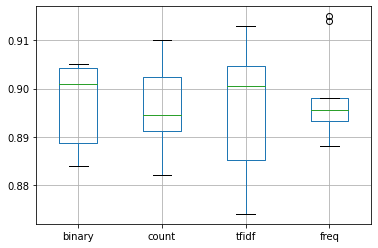

In [8]:
import seaborn as sns

results.boxplot()
plt.show()

In [9]:
results.describe()

binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.896900   0.896200   0.895900   0.898300
std     0.008412   0.008979   0.013119   0.009056
min     0.884000   0.882000   0.874000   0.888000
25%     0.888750   0.891250   0.885250   0.893250
50%     0.901000   0.894500   0.900500   0.895500
75%     0.904250   0.902500   0.904750   0.898000
max     0.905000   0.910000   0.913000   0.915000

# Training and Testing the Model 2

## MLP Model 2

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 100 neurons and Relu activation function
- Dropout layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [10]:
def train_mlp_2(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Comparing the Word Scoring Methods

In [11]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_2(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=100, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_2(Xtrain, train_y, verbose=0, epochs=2)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


mode:  binary
Test Accuracy: 89.49999809265137
Test Accuracy: 89.3999993801117
Test Accuracy: 90.2999997138977
Test Accuracy: 91.10000133514404
Test Accuracy: 90.2999997138977
Test Accuracy: 89.80000019073486
Test Accuracy: 88.99999856948853
Test Accuracy: 91.10000133514404
Test Accuracy: 90.6000018119812
Test Accuracy: 90.20000100135803
The test ccuracy for each training:
[0.89499998 0.89399999 0.903      0.91100001 0.903      0.898
 0.88999999 0.91100001 0.90600002 0.90200001]
The mean of the test accuracy:  0.9013000011444092

mode:  count
Test Accuracy: 90.20000100135803
Test Accuracy: 89.89999890327454
Test Accuracy: 91.39999747276306
Test Accuracy: 89.49999809265137
Test Accuracy: 90.2999997138977
Test Accuracy: 90.2999997138977
Test Accuracy: 90.2999997138977
Test Accuracy: 90.10000228881836
Test Accuracy: 90.79999923706055
Test Accuracy: 89.89999890327454
The test ccuracy for each training:
[0.90200001 0.89899999 0.91399997 0.89499998 0.903      0.903
 0.903      0.90100002 0.9

In [12]:
results.describe()

binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.901300   0.902700   0.898100   0.890300
std     0.007056   0.005229   0.006999   0.012841
min     0.890000   0.895000   0.888000   0.868000
25%     0.895750   0.899500   0.892750   0.885500
50%     0.902500   0.902500   0.897500   0.889000
75%     0.905250   0.903000   0.902750   0.894750
max     0.911000   0.914000   0.911000   0.914000

# Training and Testing the Model 3

## MLP Model 3

Now, we will build Multilayer Perceptron (MLP) models to classify encoded documents as either positive or negative.

As you might have expected, the models are simply feedforward network with fully connected layers called `Dense` in the `Keras` library.

Now, we will define our MLP neural network with very little trial and error so cannot be considered tuned for this problem. The configuration is as follows:
- First hidden layer with 50 neurons and Relu activation function
- Dropout layer with p = 0.5
- Output layer with Sigmoid activation function
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

In [13]:
def train_mlp_3(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Comparing the Word Scoring Methods

In [14]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_mlp_3(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense( units=50, activation='relu', input_shape=(n_words,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)

        # train the model
        model = train_mlp_3(Xtrain, train_y, verbose=0, epochs = 2)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

C:\Users\Diardano Raihan\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


mode:  binary
Test Accuracy: 89.89999890327454
Test Accuracy: 90.79999923706055
Test Accuracy: 89.99999761581421
Test Accuracy: 89.3999993801117
Test Accuracy: 90.6000018119812
Test Accuracy: 89.60000276565552
Test Accuracy: 88.40000033378601
Test Accuracy: 90.89999794960022
Test Accuracy: 89.20000195503235
Test Accuracy: 88.99999856948853
The test ccuracy for each training:
[0.89899999 0.90799999 0.89999998 0.89399999 0.90600002 0.89600003
 0.884      0.90899998 0.89200002 0.88999999]
The mean of the test accuracy:  0.8977999985218048

mode:  count
Test Accuracy: 89.49999809265137
Test Accuracy: 91.79999828338623
Test Accuracy: 89.89999890327454
Test Accuracy: 88.59999775886536
Test Accuracy: 89.20000195503235
Test Accuracy: 89.70000147819519
Test Accuracy: 89.80000019073486
Test Accuracy: 90.6000018119812
Test Accuracy: 90.39999842643738
Test Accuracy: 91.90000295639038
The test ccuracy for each training:
[0.89499998 0.91799998 0.89899999 0.88599998 0.89200002 0.89700001
 0.898      

In [15]:
results.describe()

binary      count     tfidf      freq
count  10.000000  10.000000  10.00000  10.00000
mean    0.897800   0.901400   0.90210   0.88590
std     0.008203   0.010627   0.00885   0.01113
min     0.884000   0.886000   0.89000   0.86700
25%     0.892500   0.895500   0.89575   0.87725
50%     0.897500   0.898500   0.90200   0.88800
75%     0.904500   0.905500   0.90550   0.89400
max     0.909000   0.919000   0.92100   0.90100